# GANs to Generate Grayscale Images of Clothing Items
This notebook contains code for training a Generative Adversarial Network (GAN) to generate grayscale images of clothing items using the FashionMNIST dataset.


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

### Data Preprocessing

In [2]:
# Set seed for reproducibility
torch.manual_seed(0)

# Define transformations for data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [3]:
# Load FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

100%|██████████| 26421880/26421880 [00:00<00:00, 116848685.89it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4721571.48it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 69240165.55it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6885292.41it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
# Define data loader
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [5]:
images, labels = next(iter(train_loader))
labels

tensor([3, 9, 5, 0, 9, 0, 3, 8, 3, 1, 5, 7, 4, 0, 3, 8, 2, 3, 7, 8, 7, 4, 8, 8,
        2, 6, 5, 6, 4, 7, 6, 7])

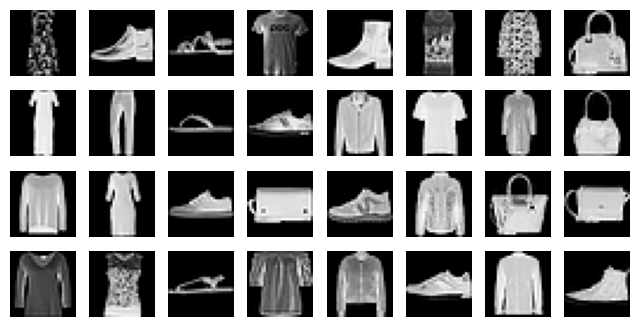

In [6]:
# Display a batch of images from the dataset
fig, ax = plt.subplots(4, 8, figsize=(8, 4))
for i in range(32):
  axis = plt.subplot(4, 8, i + 1)
  plt.imshow(images[i].squeeze(), cmap='gray')
  plt.axis('off')

### Model Architecture

In [7]:
# Check if CUDA is available for GPU acceleration
device="cuda" if torch.cuda.is_available() else "cpu"

# Define Discriminator model architecture
Discriminator = nn.Sequential(
    nn.Linear(784, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 1),
    nn.Sigmoid()).to(device)

In [8]:
# Define Generator model architecture
Generator = nn.Sequential(
    nn.Linear(100, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 784),
    nn.Tanh()).to(device)

In [9]:
# Define loss function and learning rate
loss_function = nn.BCELoss()
lr = 0.0001

# Define optimizers for Discriminator and Generator
optimD = torch.optim.Adam(Discriminator.parameters(),lr=lr)
optimG = torch.optim.Adam(Generator.parameters(),lr=lr)

In [10]:
# Function to visualize generated images
def see_output():
    noise = torch.randn(32,100).to(device=device)
    fake_samples = Generator(noise).cpu().detach()
    fig, ax = plt.subplots(4, 8, figsize=(8, 4))
    for i in range(32):
      axis = plt.subplot(4, 8, i + 1)
      plt.imshow((fake_samples[i] / 2 + 0.5).reshape(28, 28))
      plt.axis('off')
    plt.show()

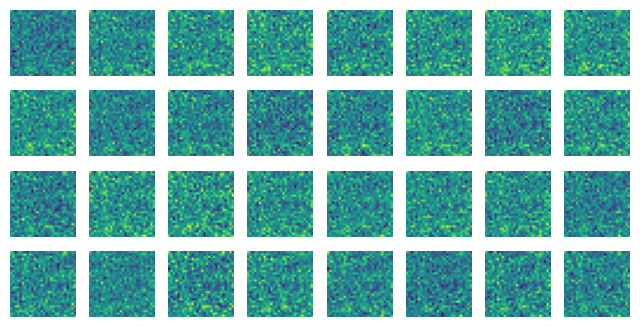

In [11]:
# Display generated images before training
see_output()

In [12]:
# Define real and fake labels for Discriminator
real_labels = torch.ones((batch_size,1)).to(device)
fake_labels = torch.zeros((batch_size,1)).to(device)

In [13]:
# Function to train Discriminator with real samples
def train_real_Discriminator(real_samples):
    r = real_samples.reshape(-1,28*28).to(device)
    output = Discriminator(r)
    labels = torch.ones((r.shape[0],1)).to(device)
    loss = loss_function(output,labels)
    optimD.zero_grad()
    loss.backward()
    optimD.step()
    return loss

In [14]:
# Function to train Discriminator with fake samples
def train_fake_Discriminator():
    noise = torch.randn(batch_size,100).to(device=device)
    generated_data = Generator(noise)
    preds = Discriminator(generated_data)
    loss = loss_function(preds, fake_labels)
    optimD.zero_grad()
    loss.backward()
    optimD.step()
    return loss

In [15]:
# Function to train Generator
def train_Generator():
    noise = torch.randn(batch_size,100).to(device=device)
    generated_data = Generator(noise)
    preds = Discriminator(generated_data)
    loss_Generator = loss_function(preds,real_labels)
    optimG.zero_grad()
    loss_Generator.backward()
    optimG.step()
    return loss_Generator

### Training

Epoch 10, discriminator loss: 0.7305876016616821, generator loss: 2.0031485557556152


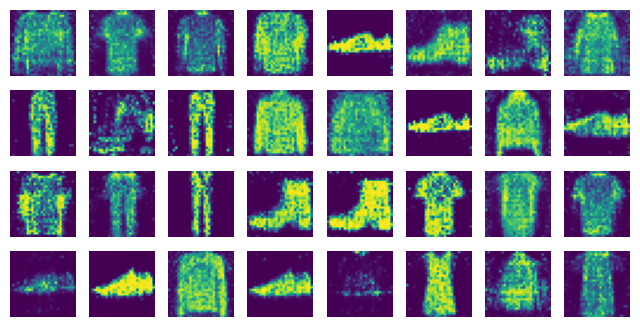

Epoch 20, discriminator loss: 1.0971028804779053, generator loss: 1.1425530910491943


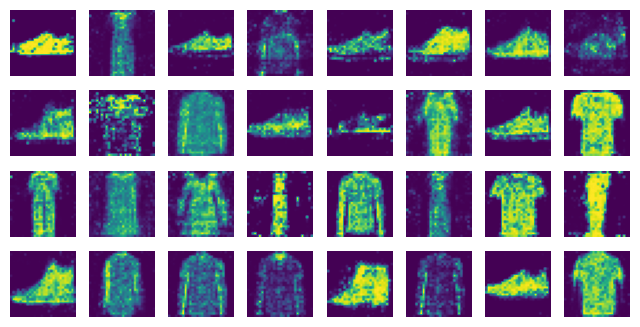

Epoch 30, discriminator loss: 1.1976165771484375, generator loss: 0.9690510630607605


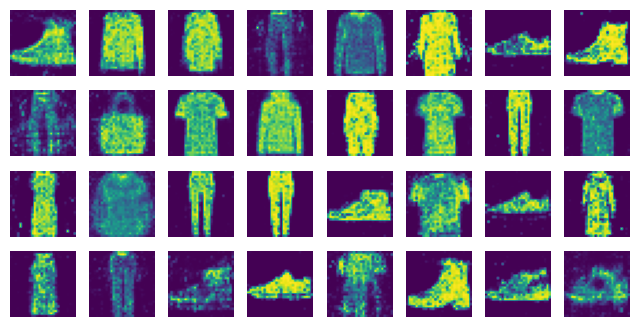

Epoch 40, discriminator loss: 1.2191599607467651, generator loss: 0.9337314963340759


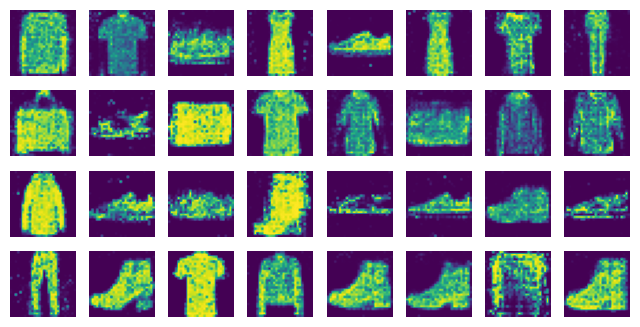

Epoch 50, discriminator loss: 1.2150120735168457, generator loss: 0.929786741733551


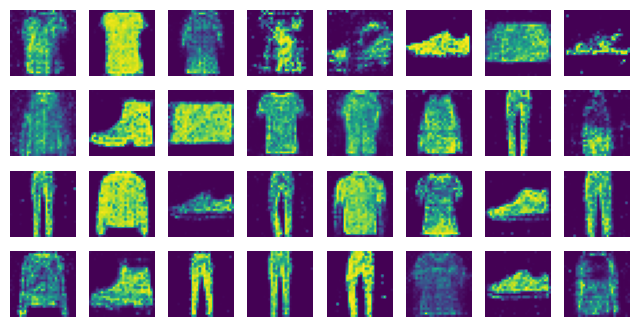

In [16]:
for i in range(50):
    generator_loss_total = 0
    discriminator_loss_total = 0
    for n, (real_samples,_) in enumerate(train_loader):
        loss_discriminator = train_real_Discriminator(real_samples)
        discriminator_loss_total += loss_discriminator
        loss_discriminator = train_fake_Discriminator()
        discriminator_loss_total += loss_discriminator
        loss_generator = train_Generator()
        generator_loss_total += loss_generator
    generator_loss_total= generator_loss_total / n
    discriminator_loss_total= discriminator_loss_total / n
    if i % 10 == 9:
        print(f"Epoch {i+1}, discriminator loss: {discriminator_loss_total}, generator loss: {generator_loss_total}")
        see_output()

### TorchScript Conversion and Model Saving

In [19]:
# Convert Generator model to TorchScript and save it
Generator_model = torch.jit.script(Generator)
import os
os.makedirs("files", exist_ok=True)
Generator_model.save('files/image_generator_fashion.pt')

### Generation of Fake Samples

In [20]:
new_Generator = torch.jit.load('files/image_generator_fashion.pt',
                     map_location=device)
new_Generator.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Linear)
  (3): RecursiveScriptModule(original_name=ReLU)
  (4): RecursiveScriptModule(original_name=Linear)
  (5): RecursiveScriptModule(original_name=ReLU)
  (6): RecursiveScriptModule(original_name=Linear)
  (7): RecursiveScriptModule(original_name=Tanh)
)

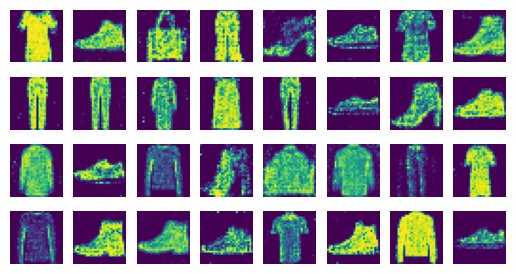

In [22]:
# Generate and display fake samples using the Generator model
noise = torch.randn(batch_size, 100).to(device=device)
fake_samples = new_Generator(noise).cpu().detach()
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow((fake_samples[i] / 2 + 0.5).reshape(28, 28))
    plt.axis('off')
plt.subplots_adjust(hspace=-0.6)
plt.show()